Intersection stations: {'Holborn', 'Waterloo', 'Oxford Circus', 'Green Park', 'Bond Street', 'Piccadilly Circus', 'Baker Street'}


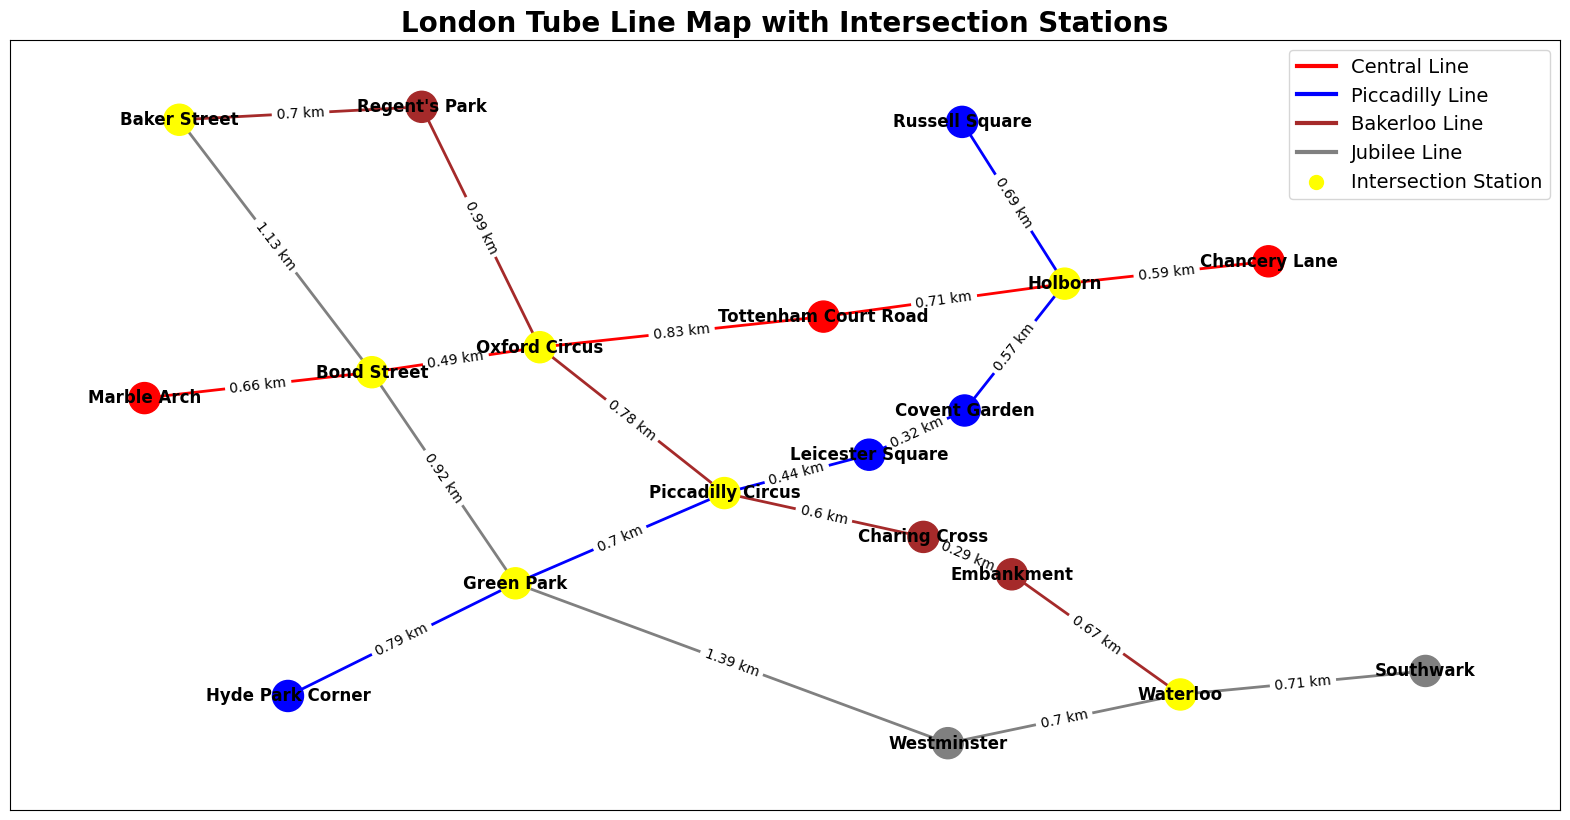

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ------------------- Data Loading -------------------
# Load the CSV file
file_path = 'London stations.csv'  # Replace with the actual file path
stations_data = pd.read_csv(file_path)
stations_data.columns = stations_data.columns.str.strip()  # Remove extra spaces

# ------------------- Haversine Function -------------------
# Define the haversine distance function to calculate the distance between two geographic points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ------------------- Graph Data Preparation -------------------
# Define edges for all lines
central_line_edges = [
    ("Marble Arch", "Bond Street"),
    ("Bond Street", "Oxford Circus"),
    ("Oxford Circus", "Tottenham Court Road"),
    ("Tottenham Court Road", "Holborn"),
    ("Holborn", "Chancery Lane")
]

piccadilly_line_edges = [
    ("Hyde Park Corner", "Green Park"),
    ("Green Park", "Piccadilly Circus"),
    ("Piccadilly Circus", "Leicester Square"),
    ("Leicester Square", "Covent Garden"),
    ("Covent Garden", "Holborn"),
    ("Holborn", "Russell Square"),
]

bakerloo_line_edges = [
    ("Waterloo", "Embankment"),
    ("Embankment", "Charing Cross"),
    ("Charing Cross", "Piccadilly Circus"),
    ("Piccadilly Circus", "Oxford Circus"),
    ("Oxford Circus", "Regent's Park"),
    ("Regent's Park", "Baker Street")
]

jubilee_line_edges = [
    ("Baker Street", "Bond Street"),
    ("Bond Street", "Green Park"),
    ("Green Park", "Westminster"),
    ("Westminster", "Waterloo"),
    ("Waterloo", "Southwark")
]

# Calculate distances and assign to edges with colors
edges = []
edge_labels = {}  # To store labels for the edges
for edge_list, color in [(central_line_edges, 'red'), (piccadilly_line_edges, 'blue'), (bakerloo_line_edges, 'brown'), (jubilee_line_edges, 'grey')]:
    for edge in edge_list:
        station1 = stations_data[stations_data['Station'] == edge[0]].iloc[0]
        station2 = stations_data[stations_data['Station'] == edge[1]].iloc[0]
        distance = haversine(station1['Latitude'], station1['Longitude'],
                             station2['Latitude'], station2['Longitude'])
        edges.append((edge[0], edge[1], round(distance, 2), color))
        edge_labels[(edge[0], edge[1])] = f"{round(distance, 2)} km"

# Create the graph and add nodes with positions
G = nx.Graph()
for _, row in stations_data.iterrows():
    G.add_node(row['Station'], pos=(row['Longitude'], row['Latitude']))

# Add edges with colors
for edge in edges:
    G.add_edge(edge[0], edge[1], color=edge[3], weight=edge[2])

# ------------------- Identify Intersection Stations -------------------
stations_by_line = {
    'central': set(station for edge in central_line_edges for station in edge),
    'piccadilly': set(station for edge in piccadilly_line_edges for station in edge),
    'bakerloo': set(station for edge in bakerloo_line_edges for station in edge),
    'jubilee': set(station for edge in jubilee_line_edges for station in edge)
}

# Find intersection stations
intersection_stations = set()
for station in G.nodes():
    line_count = sum(station in stations_by_line[line] for line in stations_by_line)
    if line_count >= 2:  # Intersects at least two lines
        intersection_stations.add(station)

print("Intersection stations:", intersection_stations)

# Assign colors to nodes
node_colors = []
for node in G.nodes():
    if node in intersection_stations:
        node_colors.append('yellow')  # Intersection of two or more lines
    elif node in stations_by_line['central']:
        node_colors.append('red')  # Central Line
    elif node in stations_by_line['piccadilly']:
        node_colors.append('blue')  # Piccadilly Line
    elif node in stations_by_line['bakerloo']:
        node_colors.append('brown')  # Bakerloo Line
    elif node in stations_by_line['jubilee']:
        node_colors.append('grey')  # Jubilee Line
    else:
        node_colors.append('black')  # Default for unexpected cases

# ------------------- Graph Visualization -------------------
plt.figure(figsize=(20, 10))

# Draw nodes
nx.draw_networkx_nodes(
    G,
    pos=nx.get_node_attributes(G, 'pos'),
    node_size=500,
    node_color=node_colors
)

# Draw edges with colors
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
nx.draw_networkx_edges(
    G,
    pos=nx.get_node_attributes(G, 'pos'),
    edge_color=edge_colors,
    width=2
)

# Draw labels for nodes
nx.draw_networkx_labels(
    G,
    pos=nx.get_node_attributes(G, 'pos'),
    font_size=12,
    font_weight='bold'
)

# Draw labels for edges (distances in km)
nx.draw_networkx_edge_labels(
    G,
    pos=nx.get_node_attributes(G, 'pos'),
    edge_labels=edge_labels,
    font_size=10
)

# Add legend
plt.plot([], [], color='red', linewidth=3, label='Central Line')
plt.plot([], [], color='blue', linewidth=3, label='Piccadilly Line')
plt.plot([], [], color='brown', linewidth=3, label='Bakerloo Line')
plt.plot([], [], color='grey', linewidth=3, label='Jubilee Line')
plt.scatter([], [], color='yellow', s=100, label='Intersection Station')
plt.legend(loc='upper right', fontsize=14)

# Add title and show the plot
plt.title("London Tube Line Map", fontsize=20, fontweight='bold')
plt.show()
